In [52]:
import tensorflow as tf
import os #used to list key directories os.listdir("data") or os.path.join('data', 'happy')
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt




In [53]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.list_physical_devices('GPU')


## Improve image quality

In [54]:
data_dir = 'data' 

image_exts = ['jpeg','jpg', 'bmp', 'png']
print (image_exts[2])

bmp


Check the folders in data directory.

In [55]:
os.listdir(data_dir)

['cyanobacteria', 'salmonella']

or you cand do this...

In [56]:
#loop through every single image in the file:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)

1-blue-green-algae-tem-omikron.jpg
1.jpg
1000_F_418796763_HDt1FmgqOcqFjVjM2t9gAZ26PQgZZ9lh.jpg
1788-111172661.jpg
19IA-220Gloeocapsa.JPG.jpg
20.jpg
20201207-AzollaFernAndCyanobacteria.jpg
21.jpg
22.jpg
221259379.jpg
24.jpg
256px-TolypothrixCyanobacteria.jpg
300px-CyanobacteriaMicroscope.jpeg
36.jpg
360_F_287343093_IPxPTLPq00BAuR9YjunSv0jwFC54m7eu.jpg
36587553290_6630202564_z.jpg
39.jpg
4-anabaena-cyanobacteria-marek-mis.jpg
40.jpg
41.jpg
7-cyanobacteriacollage_orig.jpg
9fcce0cfb7981d1688079e93e2a8e5d6.jpg
a-0005.jpg
a-0646.jpg
a-newly-discovered-microscopic-global-source-of-methane.jpeg
algae-oscillatoria-filaments-polarized-light-with-crossed-polarizers-2H3W5T9.jpg
anabaena-from-blue-lakes_orig.jpg
anabaena_1_orig.jpg
aphanizomenon3_dempsey_landing_ct_may172017.jpg
AS1206-86c526245a5de26f12398bc131db0ee1.jpg
AS74-41111b1f051440795a7d86d41582eeab.jpg
bdbath5b.jpg
bioengineering-04-00026-g001.png
c0198949-800px-wm.jpg
c8588d58f51a095bdad1d2e728df2f60--microbiology.jpg
Cell-morphology-of

In [57]:
img = cv2.imread(os.path.join('data', 'cyanobacteria', '1.jpg'))
img.shape #480px high, 853 width, 3 channels/color image (row, column, )

(480, 853, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

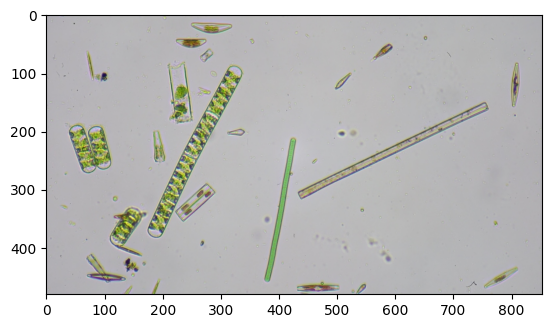

In [58]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGBA))
plt.show

## Check for any incompatiable images

In [59]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


## Load Data

Data pipeline Dataset api--> via use keras utility

In [60]:
data = tf.keras.utils.image_dataset_from_directory('data') #builds image dataset on the fly-->resizes them ?? for more info.
data_iterator = data.as_numpy_iterator() #consecutive batch method
batch = data_iterator.next() #batch --> set of loaded images as a numpy array


Found 301 files belonging to 2 classes.


In [61]:
len(batch) #images


2

In [62]:
batch[0].shape 
#automatically resizes images. Images represented as numpy arrays. Labels batch[1]
#3 in the shape is channels(in this case RGB).


(32, 256, 256, 3)

In [63]:
batch[1]


array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0])

You can change the batch by using--> tf.keras.utils.image_dataset_from_directory('data', batch_size=8, image_size=(128,128))

Below, 1 i= salmonella and = 0 is represented as cyanobacteria. 

## Scale Data

Next, we normalize the image to avoid the possibility of exploding gradients because of the high range of the pixels [0, 255], and improve the convergence speed. Therefore, you either standardize the each image, so that the range is [-1, 1] or you just divide the with the maximum pixel value as you are doing, so that the range of the pixels is in the [0, 1] range.

In [64]:
data = data.map(lambda x, y: (x/255, y))



In [65]:
scaled_iterator = data.as_numpy_iterator()


In [66]:
batch = scaled_iterator.next()

In [67]:
batch[0].max()

1.0

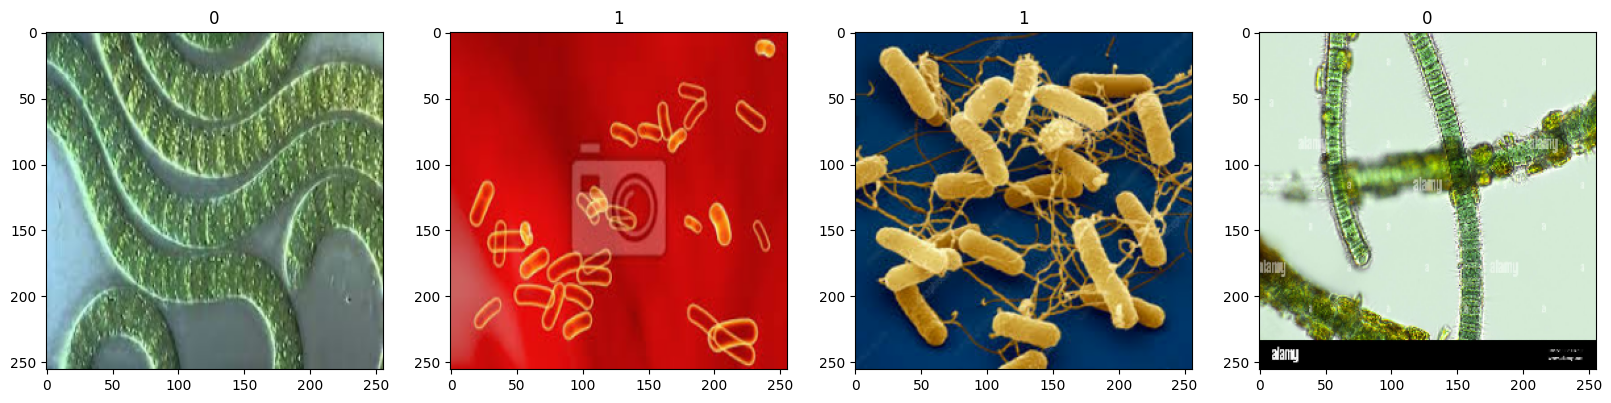

In [68]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


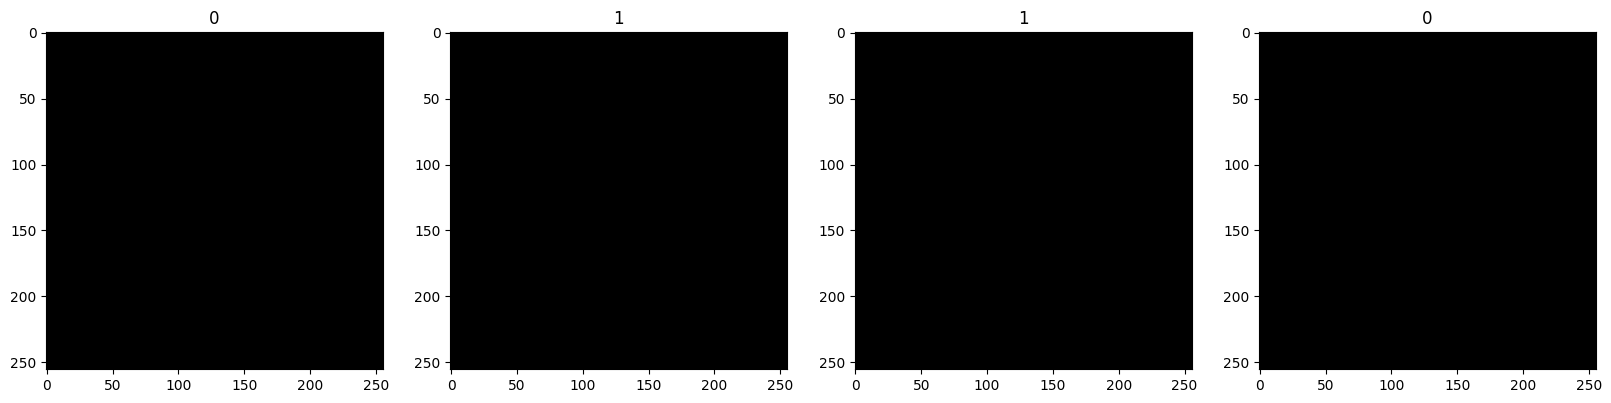

In [69]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


## Split Data

Makes sure it is not overfit. Each batch will have 32 images. In this case when we look at the length of the data there are 10 batches containing 32 images in each. 

In [70]:
len(data)

10

In [71]:
train_size = int(len(data)*.7) #trainning set is 70% of data.
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1


In [72]:
train_size


7

In [73]:
val_size

3

In [74]:
test_size

2

Take is how much data you will take in a particular partician.

In [75]:

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [76]:
len(train)

7

## Deep Learning Model

Sequential: Used when you have one data input and one output -->flows from top to bottom.
Functional Api is good for multiple collections.

In [77]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

train
 

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [78]:
model = Sequential()

Hyperparameters and architecture

In [79]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu')) #relu convers negative numbers to positive numbers.
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [80]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

## Train

In [82]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 6s 735ms/step - loss: 0.6966 - accuracy: 0.6161 - val_loss: 0.8522 - val_accuracy: 0.6234
Epoch 2/20
7/7 [==============================] - 6s 732ms/step - loss: 0.5069 - accuracy: 0.7946 - val_loss: 0.4483 - val_accuracy: 0.8442
Epoch 3/20
7/7 [==============================] - 6s 719ms/step - loss: 0.5285 - accuracy: 0.7277 - val_loss: 0.5044 - val_accuracy: 0.7273
Epoch 4/20
7/7 [==============================] - 6s 717ms/step - loss: 0.4565 - accuracy: 0.7812 - val_loss: 0.4050 - val_accuracy: 0.8182
Epoch 5/20
7/7 [==============================] - 5s 697ms/step - loss: 0.3438 - accuracy: 0.8348 - val_loss: 0.2332 - val_accuracy: 0.9091
Epoch 6/20
7/7 [==============================] - 6s 695ms/step - loss: 0.3107 - accuracy: 0.8527 - val_loss: 0.2429 - val_accuracy: 0.8571
Epoch 7/20
7/7 [==============================] - 5s 695ms/step - loss: 0.2542 - accuracy: 0.8929 - val_loss: 0.3411 - val_accuracy: 0.7922
Epoch 8/20
7/7 [====

## Plot Performance

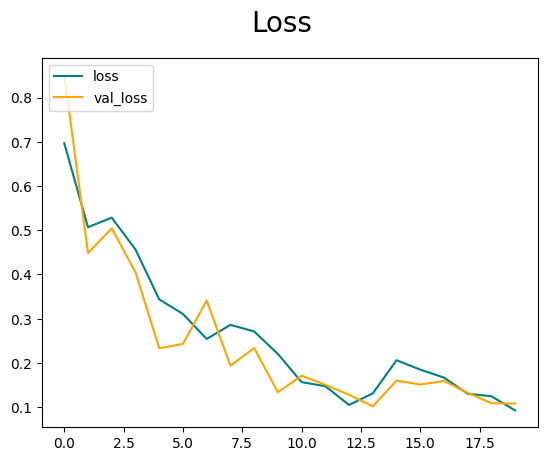

In [83]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

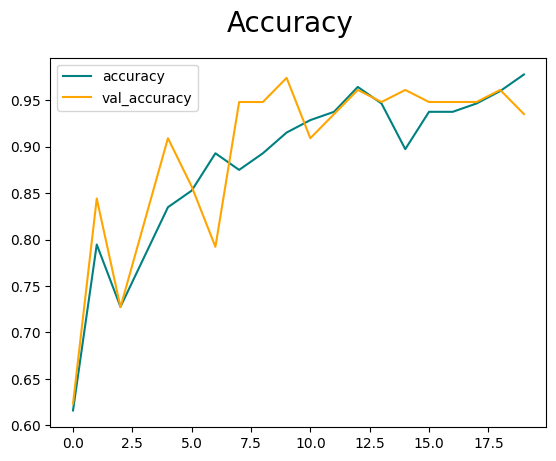

In [84]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

In [98]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [99]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [100]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [101]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


## Test

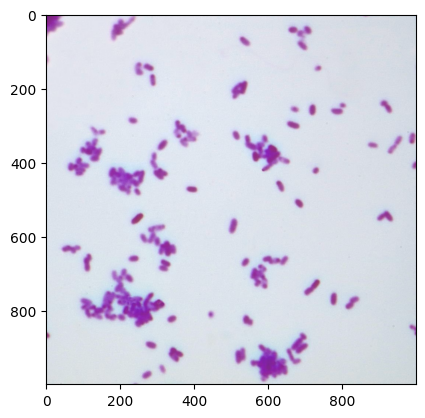

In [110]:
img = cv2.imread('test2.jpg')
plt.imshow(img)
plt.show()

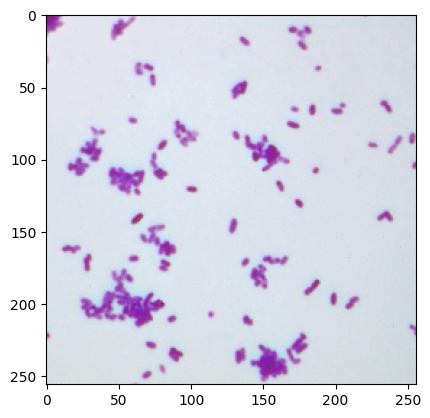

In [111]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [112]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [113]:
yhat

array([[0.9945647]], dtype=float32)

In [114]:
if yhat > 0.5: 
    print(f'Predicted class is Salmonella')
else:
    print(f'Predicted class is Cyanobacteria')

Predicted class is Salmonella


## Save Model

In [115]:
from keras.models import load_model

In [116]:
model.save(os.path.join('models','imageclassifier.h5'))

In [117]:
new_model = load_model('./models/imageclassifier.h5')

In [118]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.9945647]], dtype=float32)